# 3.1 Testing of Final Models

In [1]:
import mcnultymod
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     cross_val_score,
                                     # cross_val_predict,
                                     learning_curve,
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV
                                     # KFold
                                    )

from datetime import datetime, timedelta, date
# import os
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [2]:
auctions = pd.read_pickle('../data/auctionsclosed_v2.pkl')
auctions_test = pd.read_pickle('../data/auctionsclosed_test_v2.pkl')

In [3]:
auctions_short = (auctions
                     .filter(['ptype_num',
                              'p_bin',
                              'n_bin',
                              'thr_0',
                              'tcount_2'
                             ]))

auctions_test_short = (auctions_test
                     .filter(['ptype_num',
                              'p_bin',
                              'n_bin',
                              'thr_0',
                              'tcount_2'
                             ]))

In [4]:
auctions_short.shape

(1043, 5)

In [5]:
auctions_test_short.shape

(261, 5)

In [6]:
y_train = auctions_short.iloc[:, 0]
X_train = auctions_short.iloc[:, 1:]
y_test = auctions_test_short.iloc[:, 0]
X_test = auctions_test_short.iloc[:, 1:]

In [7]:
X_train_std, X_test_std = mcnultymod.prep_X(X_train.columns[:-1], [X_train, X_test])

/Users/dluther/ds/metis/metisgh/projects/Proj-03-McNulty/code/mcnultymod.py:486: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[col] = X[col].astype('category')


In [10]:
# set random state value
rs = 23

In [14]:
# initialize models

rf = RandomForestClassifier(n_estimators=5000,
                             max_depth=2,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=rs,
                             class_weight='balanced'
                            )

lr = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced', random_state=rs)

svc = LinearSVC(C=0.2, class_weight='balanced', random_state=rs)

In [15]:
# fit models
modlist = [rf, lr, svc]
names = ["Random Forest (5000 trees, max depth 2",
         "Logistic Regression (C=0.1, L2 penalty)",
         "Linear SVC (C=0.2)"
        ]

for model in modlist:
    model.fit(X_train_std, y_train)

In [16]:
# predict and look at scores
# score_types = ['accuracy',
#                'precision',
#                'recall',
#                'f1'
#               ]

model_scores = {}

for name, model in zip(names, modlist):
    model_scores[name] = []
    y_hat = model.predict(X_test_std)
    model_scores[name].append(metrics.accuracy_score(y_test, y_hat))
    model_scores[name].append(metrics.precision_score(y_test, y_hat))
    model_scores[name].append(metrics.recall_score(y_test, y_hat))
    model_scores[name].append(metrics.f1_score(y_test, y_hat))

In [17]:
for name in names:
    mcnultymod.print_scores(name, model_scores[name])


Random Forest (5000 trees, max depth 2
*    Accuracy:   0.5479
*    Precision:  0.3173
*    Recall:     0.4125
*    F1:         0.3587

Logistic Regression (C=0.1, L2 penalty)
*    Accuracy:   0.5096
*    Precision:  0.3235
*    Recall:     0.55
*    F1:         0.4074

Linear SVC (C=0.2)
*    Accuracy:   0.4981
*    Precision:  0.3139
*    Recall:     0.5375
*    F1:         0.3963


### ROC and Other Viz

In [18]:
def roc_out(X, y, model_name, model):
    """
    Draws ROC curve and returns AUC + log loss as well.
    ---
    IN
    X_test_std:
    y_test:
    model_name: name of model type (str)
    model: sklearn classifier object, already fit
    OUT
    auc: area under curve (float)
    matplotlib object
    """

    y_hat = model.predict(X)
    y_score = model.predict_proba(X)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    ll = metrics.log_loss(y, y_hat)

    plt.figure(figsize=(8,8))
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f"{model_name}")
    
    return roc_auc, ll

Random Forest (5000 trees, max depth 2
AUC: 0.5009
Log Loss: 15.6154 

Logistic Regression (C=0.1, L2 penalty)
AUC: 0.5114
Log Loss: 16.9388 



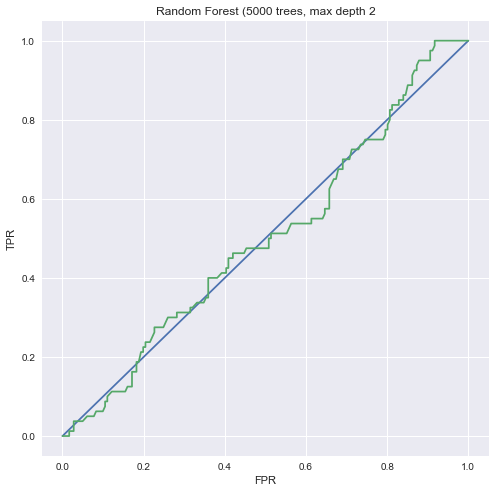

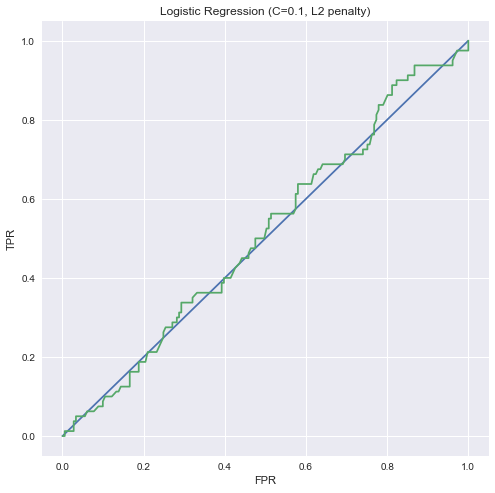

In [19]:
for name, model in zip(names[:-1], modlist[:-1]):
    print(name)
    auc, log_loss = roc_out(X_test_std, y_test, name, model)
    print("AUC:", round(auc, 4))
    print("Log Loss:", round(log_loss, 4), '\n')

In [29]:
dummy_scores = mcnultymod.the_dummy(y_test)
mcnultymod.print_scores('Dummy (guessing Investor)', dummy_scores)


Dummy (guessing Investor)
*    Accuracy:   0.3065
*    Precision:  0.3065
*    Recall:     1.0
*    F1:         0.4692


In [20]:
model_scores

{'Linear SVC (C=0.2)': [0.49808429118773945,
  0.31386861313868614,
  0.53749999999999998,
  0.39631336405529949],
 'Logistic Regression (C=0.1, L2 penalty)': [0.50957854406130265,
  0.3235294117647059,
  0.55000000000000004,
  0.4074074074074075],
 'Random Forest (5000 trees, max depth 2': [0.54789272030651337,
  0.31730769230769229,
  0.41249999999999998,
  0.35869565217391303]}

''

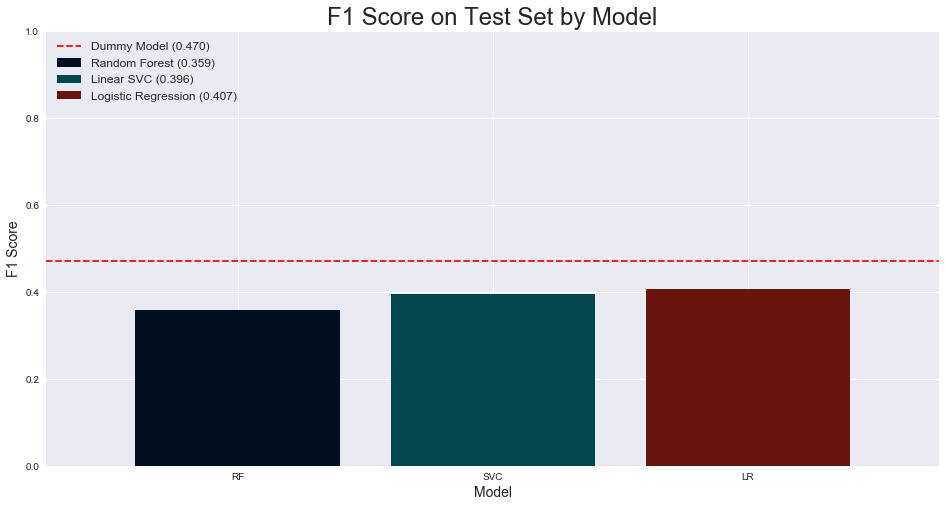

In [58]:
x_labels = ['Logistic Regression,' 'Linear SVC', 'Random Forest']
x = [-0.75, 2.75]
y_dummy = [0.47] * 2
x_lr = [2]
y_lr = [0.407]
x_svc = [1]
y_svc = [0.396]
x_rf = [0]
y_rf = [0.359]

plt.figure(figsize=(16,8))
plt.plot(x, y_dummy, 'r--', label='Dummy Model (0.470)')
plt.bar(x_rf, y_rf, color='#001021', label='Random Forest (0.359)')
plt.bar(x_svc, y_svc, color='#02474B', label='Linear SVC (0.396)')
plt.bar(x_lr, y_lr, color='#69140E', label='Logistic Regression (0.407)')
plt.xlim(-0.75,2.75)
plt.ylim(0,1)
plt.xticks([0, 1, 2], ['RF', 'SVC', 'LR'])
plt.xlabel("Model", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.title("F1 Score on Test Set by Model", fontsize=24)

# plt.savefig('../img/f1_test.png', dpi=200, bbox_inches = 'tight')
;